In [1]:
import numpy as np
import pandas as pd
from scipy import stats,spatial,sparse
from sklearn import manifold,datasets,neighbors, decomposition
import time
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import matplotlib as mpl

In [2]:
def correlation_comparation(list_A,list_B):
    pearsonr_res = stats.pearsonr(list_A, list_B)
    spearmanr_res = stats.spearmanr(list_A, list_B) 
    tau, p_value = stats.kendalltau(list_A, list_B)
    return pearsonr_res.statistic,spearmanr_res.statistic,tau

In [3]:
def adjacency_dist_matrix(data,k_neighbors,root_indices):
    
    n_samples = data.shape[0]
    nbrs = neighbors.NearestNeighbors(n_neighbors=k_neighbors, metric='euclidean').fit(data)
    knn_dists, knn_indices = nbrs.kneighbors(data)
        
    indptr = range(0,(n_samples+1)*k_neighbors,k_neighbors)
    k_matrix = sparse.csr_matrix((knn_dists.flatten(),knn_indices.flatten(),indptr),shape=(n_samples,n_samples))
    adjacency_matrix = k_matrix.maximum(k_matrix.T) 
    
    geo_matrix = sparse.csgraph.dijkstra(csgraph=adjacency_matrix, directed=False, indices=root_indices, return_predecessors=False)
    
    return adjacency_matrix,geo_matrix 

In [4]:
lymphoid_dpt_pseudotime = pd.read_csv('lymphoid.dpt_pseudotime.csv',index_col=0).values.reshape(-1)
lymphoid_palantir_time = pd.read_csv("lymphoid.palantir_pseudotime.csv",index_col=0).values.reshape(-1)
lymphoid_monocle_time = pd.read_csv("lymphoid.monocle_pseudotime.csv",index_col=0).values.reshape(-1)
lymphoid_dtne_time = pd.read_csv("lymphoid.dtne_pseudotime.csv",index_col=0).values.reshape(-1)

In [5]:
lymphoid_lsi = pd.read_csv("lymphoid_lsi.csv", sep=",",index_col=0)
# the first LSI dimension is highly correlated with sequencing depth in that case, as sometimes happens with scATAC-seq data. 
# For this reason we discard the first component for downstream analysis.
lymphoid_lsi2 = lymphoid_lsi.iloc[:,1:50]

In [6]:
adj,geo = adjacency_dist_matrix(lymphoid_lsi2,30,3047)

In [7]:
lymphoid_dtne_corr = correlation_comparation(geo,lymphoid_dtne_time)
lymphoid_dtne_corr

(0.4309279677666277, 0.6676990284339742, 0.507411527833147)

In [8]:
lymphoid_dpt_corr = correlation_comparation(geo,lymphoid_dpt_pseudotime)
lymphoid_dpt_corr

(0.3663494624335105, 0.6386958511897738, 0.48153411638522314)

In [9]:
lymphoid_palantir_corr = correlation_comparation(geo,lymphoid_palantir_time)
lymphoid_palantir_corr

(0.28723514031293323, 0.6085371297664522, 0.4519334645621518)

In [10]:
lymphoid_monocle_corr = correlation_comparation(geo,lymphoid_monocle_time)
lymphoid_monocle_corr

(0.39147533114864264, 0.6471476661309442, 0.4743928073702534)

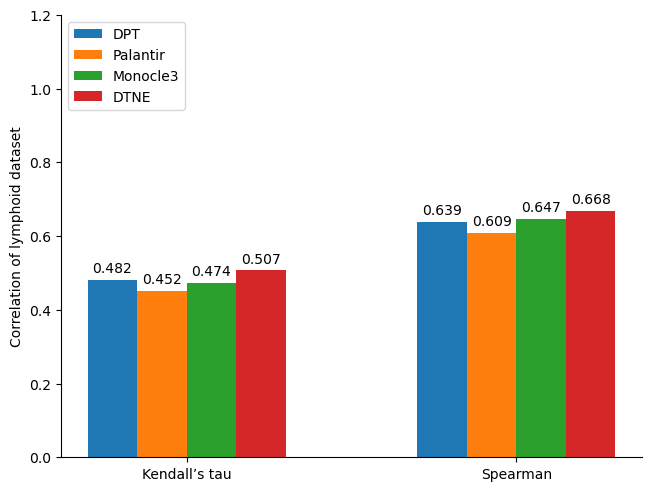

In [25]:
correlation = ['Kendall’s tau','Spearman']
pseudotime_corr = {
    'DPT':(0.482, 0.639),
    'Palantir':(0.452, 0.609),
    'Monocle3':(0.474, 0.647),
    'DTNE':(0.507, 0.668)
    }

x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, corr, width, label=name)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Correlation of lymphoid dataset')
ax.set_xticks(x + 1.5*width, correlation)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 1.2)

sns.despine(top=True,right=True,left=False,bottom=False,)
# ax.grid(False)
# ax.tick_params(bottom=True, left=True)

plt.show()

In [26]:
import matplotlib.gridspec as gridspec

In [27]:
geo = geo/max(geo)

Text(0.5, 0, 'DTNE')

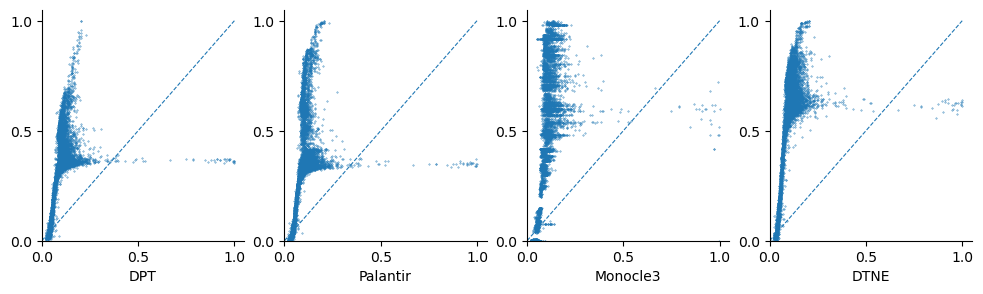

In [28]:
fig = plt.figure(figsize=(12, 3))

gs1 = gridspec.GridSpec(1, 4)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs1[2])
ax4 = fig.add_subplot(gs1[3])

x = np.linspace(0, 1, 100)
y = x

for side in ['right','top']:
        ax1.spines[side].set_visible(False)    
ax1.plot(x, y,linestyle='--',c='tab:blue',lw=.8)
ax1.set_xlim(0, 1.05)
ax1.set_ylim(0, 1.05)
ax1.set_yticks([0,0.5,1])
ax1.scatter(geo,lymphoid_dpt_pseudotime,s=0.1)
ax1.set_xlabel('DPT')

for side in ['right','top']:
        ax2.spines[side].set_visible(False) 
ax2.plot(x, y,linestyle='--',c='tab:blue',lw=.8)
ax2.set_xlim(0, 1.05)
ax2.set_ylim(0, 1.05)
ax2.set_yticks([0,0.5,1])
ax2.scatter(geo,lymphoid_palantir_time,s=0.1)
ax2.set_xlabel('Palantir')

for side in ['right','top']:
        ax3.spines[side].set_visible(False) 
ax3.plot(x, y,linestyle='--',c='tab:blue',lw=.8)
ax3.set_xlim(0, 1.05)
ax3.set_ylim(0, 1.05)
ax3.set_yticks([0,0.5,1])
ax3.scatter(geo,lymphoid_monocle_time,s=0.1)
ax3.set_xlabel('Monocle3')

for side in ['right','top']:
        ax4.spines[side].set_visible(False) 
ax4.plot(x, y,linestyle='--',c='tab:blue',lw=.8)
ax4.set_xlim(0, 1.05)
ax4.set_ylim(0, 1.05)
ax4.set_yticks([0,0.5,1])
ax4.scatter(geo,lymphoid_dtne_time,s=0.1)
ax4.set_xlabel('DTNE')

In [29]:
list_ss = []
list_s = []
for i in range(len(geo)):
    if geo[i] > 0.5:
        list_ss.append(i)
        list_s.append(1)
    else:
        list_s.append(0)

In [30]:
len(list_ss)

31

In [33]:
sorted(geo)[-32:]

[0.48907472834975235,
 0.5219321547140297,
 0.5237381961844447,
 0.5381247434653962,
 0.6670031482985278,
 0.7498512581108285,
 0.7869628661725138,
 0.7873259658698497,
 0.8449543048852771,
 0.8646186372704521,
 0.8767948751352271,
 0.8930761227525533,
 0.9007739932114454,
 0.9103462370837243,
 0.9107665027824676,
 0.9251476336069407,
 0.9269490195174198,
 0.9481014155122943,
 0.9484522213099521,
 0.9502146018854256,
 0.9576812915650359,
 0.9624523137495946,
 0.9699302350825276,
 0.9711465187969235,
 0.9715520856572293,
 0.977559472257321,
 0.9915631334077514,
 0.9940593409192374,
 0.9960914234166967,
 0.9968573331561857,
 0.9971552022060456,
 1.0]

In [34]:
lymphoid_celltype = pd.read_csv("lymphoid_celltype.csv", sep=",",index_col=0)
lymphoid_celltype_values = lymphoid_celltype['x'].values

In [35]:
lymphoid_celltype_values[list_ss]

array(['GMP', 'GMP', 'GMP', 'MDP', 'GMP', 'MDP', 'GMP', 'GMP', 'MDP',
       'GMP', 'MDP', 'Pro-B', 'MDP', 'Pro-B', 'GMP', 'GMP', 'GMP', 'MDP',
       'GMP', 'GMP', 'GMP', 'GMP', 'GMP', 'MDP', 'MDP', 'MDP', 'MDP',
       'GMP', 'MDP', 'MDP', 'GMP'], dtype=object)

In [36]:
lymphoid_Y_umap = pd.read_csv("../1_lymphoid/lymphoid.Y_umap.csv",index_col=0)

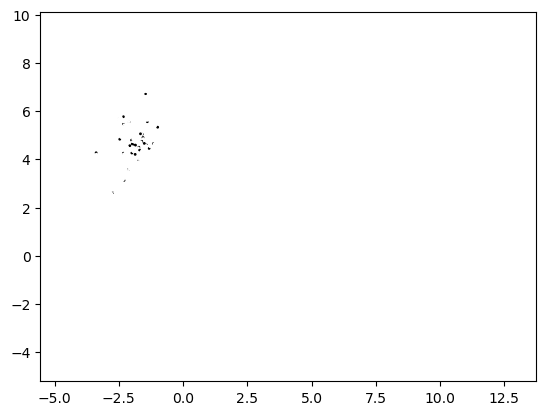

In [37]:
plt.scatter(x=lymphoid_Y_umap['0'], y=lymphoid_Y_umap['1'], c = list_s, s = 1,cmap='Grays') # c=cluster_colors[i],

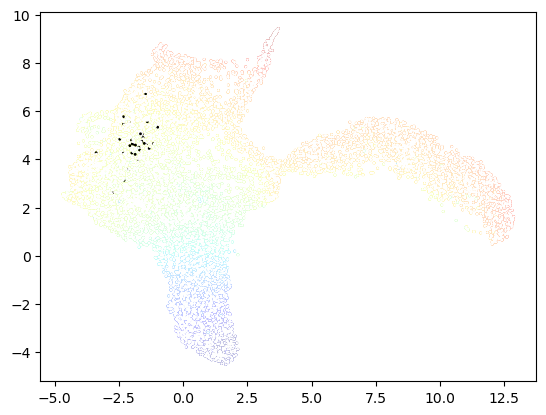

In [38]:
plt.scatter(x=lymphoid_Y_umap['0'], y=lymphoid_Y_umap['1'], c = lymphoid_dtne_time, s = 1,cmap='jet')
plt.scatter(x=lymphoid_Y_umap['0'], y=lymphoid_Y_umap['1'], c = list_s, s = 1,cmap='Grays')